# **PROYECTO FINAL: CALIFICACION AUTOMÁTICA DE HOJAS DE PRUEBAS**

## Autores: Arteaga Rodríguez Aarón y Aguilar Villanueva Carlos

## **1. Cargar Librerias**

In [2]:
import cv2 #Libreria de imagenes
import numpy as np #Operaciones con matrizes
import imutils
from imutils.perspective import four_point_transform 
from imutils import contours #Obtener contornos
import matplotlib.pyplot as plt
import sys

### **1.1. Funciones Extra**

In [3]:
# define names of each possible ArUco tag OpenCV supports
ARUCO_DICT = {
    "DICT_4X4_50": cv2.aruco.DICT_4X4_50,
    "DICT_4X4_100": cv2.aruco.DICT_4X4_100,
    "DICT_4X4_250": cv2.aruco.DICT_4X4_250,
    "DICT_4X4_1000": cv2.aruco.DICT_4X4_1000,
    "DICT_5X5_50": cv2.aruco.DICT_5X5_50,
    "DICT_5X5_100": cv2.aruco.DICT_5X5_100,
    "DICT_5X5_250": cv2.aruco.DICT_5X5_250,
    "DICT_5X5_1000": cv2.aruco.DICT_5X5_1000,
    "DICT_6X6_50": cv2.aruco.DICT_6X6_50,
    "DICT_6X6_100": cv2.aruco.DICT_6X6_100,
    "DICT_6X6_250": cv2.aruco.DICT_6X6_250,
    "DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
    "DICT_7X7_50": cv2.aruco.DICT_7X7_50,
    "DICT_7X7_100": cv2.aruco.DICT_7X7_100,
    "DICT_7X7_250": cv2.aruco.DICT_7X7_250,
    "DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
    "DICT_ARUCO_ORIGINAL": cv2.aruco.DICT_ARUCO_ORIGINAL,
}

def detect_aruco_marker(image_, aruco_type="DICT_ARUCO_ORIGINAL"):
    # load the input image from disk and resize it
    print("[INFO] loading image...")
    image = image_
    if image is None:
        print(f"[ERROR] Could not read image from path.")
        sys.exit(1)
    
    # verify that the supplied ArUCo tag exists and is supported by OpenCV
    if ARUCO_DICT.get(aruco_type, None) is None:
        print("[INFO] ArUCo tag of '{}' is not supported".format(aruco_type))
        sys.exit(0)
    
    # load the ArUCo dictionary, grab the ArUCo parameters, and detect the markers
    print("[INFO] detecting '{}' tags...".format(aruco_type))
    arucoDict = cv2.aruco.getPredefinedDictionary(ARUCO_DICT[aruco_type])
    arucoParams = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(arucoDict, arucoParams)

    # detect the markers
    (corners, ids, rejected) = detector.detectMarkers(image)
    
    # dictionary to store the positions of the detected markers
    marker_positions = {}

    # verify *at least* one ArUco marker was detected
    if len(corners) > 0:
        # flatten the ArUco IDs list
        ids = ids.flatten() if ids is not None else []

        # loop over the detected ArUCo corners
        for (markerCorner, markerID) in zip(corners, ids):
            # extract the marker corners (which are always returned in top-left, top-right, bottom-right, and bottom-left order)
            corners = markerCorner.reshape((4, 2))
            (topLeft, topRight, bottomRight, bottomLeft) = corners
            # convert each of the (x, y)-coordinate pairs to integers
            topRight = (int(topRight[0]), int(topRight[1]))
            bottomRight = (int(bottomRight[0]), int(bottomRight[1]))
            bottomLeft = (int(bottomLeft[0]), int(bottomLeft[1]))
            topLeft = (int(topLeft[0]), int(topLeft[1]))

            # Save marker positions in a dictionary
            marker_positions[markerID] = {
                "topLeft": (topLeft[0], topLeft[1]),
                "topRight": (topRight[0], topRight[1]),
                "bottomRight": (bottomRight[0], bottomRight[1]),
                "bottomLeft": (bottomLeft[0], bottomLeft[1]),
                "center": (int((topLeft[0] + bottomRight[0]) / 2.0), int((topLeft[1] + bottomRight[1]) / 2.0))
            }

            # draw the bounding box of the ArUCo detection
            cv2.line(image, topLeft, topRight, (0, 255, 0), 2)
            cv2.line(image, topRight, bottomRight, (0, 255, 0), 2)
            cv2.line(image, bottomRight, bottomLeft, (0, 255, 0), 2)
            cv2.line(image, bottomLeft, topLeft, (0, 255, 0), 2)
            # draw the center of the marker
            cX = marker_positions[markerID]["center"][0]
            cY = marker_positions[markerID]["center"][1]
            cv2.circle(image, (cX, cY), 4, (0, 0, 255), -1)
            # draw the ArUco marker ID on the image
            cv2.putText(image, str(markerID), (topLeft[0], topLeft[1] - 15), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 0), 10)
            print("[INFO] ArUco marker ID: {}".format(markerID))
        
        image = imutils.resize(image, width=1000)
        
        # show the output image
        plt.imshow(imutils.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), width=800)) # Mostrar imagen en 800px
        plt.axis("off")
    else:
        print("[INFO] No ArUco markers detected")

    # return the dictionary of marker positions
    return marker_positions


def crop_image(image, point1, point2):
    """
    Recorta la imagen dada según las coordenadas de dos puntos opuestos.

    :param image: Imagen de entrada (matriz de imagen).
    :param point1: Primer punto (x1, y1).
    :param point2: Segundo punto (x2, y2), opuesto al primer punto.
    :return: Imagen recortada.
    """
    # Determinar las coordenadas del recorte
    x1, y1 = point1
    x2, y2 = point2

    # Obtener los límites del área a recortar
    x_start = min(x1, x2)
    y_start = min(y1, y2)
    x_end = max(x1, x2)
    y_end = max(y1, y2)

    # Recortar la imagen
    cropped_image = image[y_start:y_end, x_start:x_end]
    
    return cropped_image

# Función para calcular el porcentaje de píxeles pintados dentro de un círculo
def filled_percentage(image, x, y, r):
    mask = np.zeros_like(image)
    cv2.circle(mask, (x, y), r, 255, -1)
    circle_pixels = np.sum(mask == 255)
    filled_pixels = np.sum(cv2.bitwise_and(image, mask) == 255)
    return (filled_pixels / circle_pixels) * 100


## **2. Cargar Imagen de la Cartilla**

(-0.5, 799.5, 598.5, -0.5)

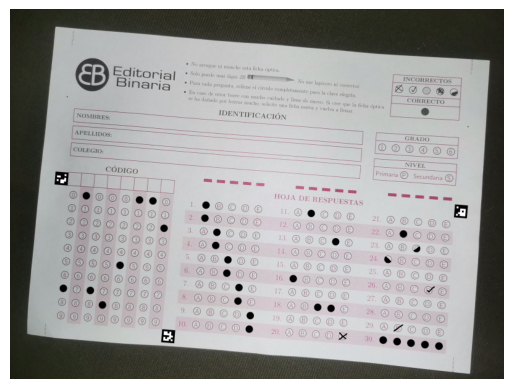

In [4]:
imagen_cartilla = cv2.imread('./images/Respuestas_Aruco.png') # Leer imagen
plt.imshow(imutils.resize(cv2.cvtColor(imagen_cartilla, cv2.COLOR_BGR2RGB), width=800)) # Mostrar imagen en 800px
plt.axis("off")

## **3. Ajuste de Dimensiones y Perspectiva de la Imagen**

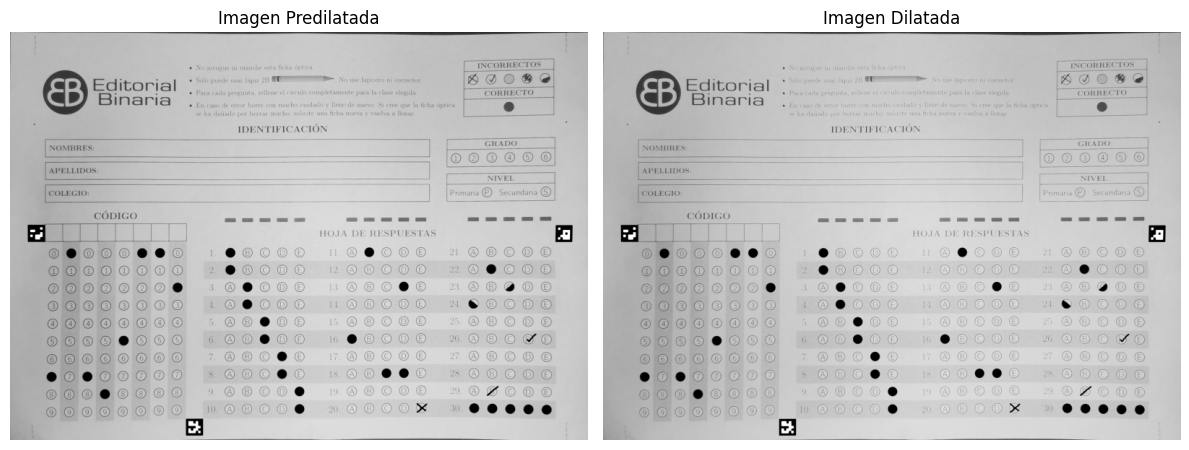

In [5]:
import cv2
import numpy as np

ratio = imagen_cartilla.shape[0] / 500.0
orig = imagen_cartilla.copy()
imagen = imutils.resize(imagen_cartilla, height = 500)

# Aplicar el preprocesamiento
imagenEscalaGrises=cv2.cvtColor(imagen,cv2.COLOR_BGR2GRAY)
# Aplicar Filtro gausiano
imagenblur=cv2.GaussianBlur(imagenEscalaGrises,(5,5),0)
#Aplicar un algoritmo de detección de bordes
imagenBordes=cv2.Canny(imagenblur, 75, 200) # Cambiar en Caso se use lapiz

#Encontrar contornos externos
"""
    Los objetos que no nos interesa como el fondo de una mesa 
    Devolver una tupla que que son dos elemento 
    Matriz de contornos y un segundo parametro que es jerarquia
"""
imagenContornos=cv2.findContours(imagenBordes.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
#Arreglar la perspectiva de la imagen eliminar lo externo y enfocarme en la hoja
#imagenContornos es una matriz desordenada
imagenContornos=imutils.grab_contours(imagenContornos)

cnts = sorted(imagenContornos, key = cv2.contourArea, reverse = True)[:5]
# loop over the contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
	# if our approximated contour has four points, then we
	# can assume that we have found our screen
	if len(approx) == 4:
		screenCnt = approx
		break

# Transformar la perspectiva de la imagen
# apply the four point transform to obtain a top-down
# view of the original image
cartilla_warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
cartilla_warped = cv2.cvtColor(cartilla_warped, cv2.COLOR_BGR2GRAY)
# Define the circular kernel

cartilla_warped = cv2.medianBlur(cartilla_warped, 5)
kernel_size = 2
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (kernel_size, kernel_size))

# Perform dilation with the circular kernel
dilated_image = cv2.dilate(cartilla_warped, kernel)
# Mostrar Secciones
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(imutils.resize(cv2.cvtColor(cartilla_warped, cv2.COLOR_BGR2RGB), width=800))
ax1.axis("off")
ax1.set_title("Imagen Predilatada")

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(imutils.resize(cv2.cvtColor(dilated_image, cv2.COLOR_BGR2RGB), width=800))
ax2.axis("off")
ax2.set_title("Imagen Dilatada")

plt.tight_layout()
plt.show()

## **4. Detección de Marcadores**

[INFO] loading image...
[INFO] detecting 'DICT_5X5_1000' tags...
[INFO] ArUco marker ID: 1
[INFO] ArUco marker ID: 2
[INFO] ArUco marker ID: 3
Marcadores detectados:  {1: {'topLeft': (101, 1081), 'topRight': (195, 1084), 'bottomRight': (194, 1176), 'bottomLeft': (100, 1174), 'center': (147, 1128)}, 2: {'topLeft': (987, 2168), 'topRight': (1080, 2169), 'bottomRight': (1078, 2261), 'bottomLeft': (986, 2260), 'center': (1032, 2214)}, 3: {'topLeft': (3057, 1083), 'topRight': (3149, 1085), 'bottomRight': (3146, 1177), 'bottomLeft': (3054, 1175), 'center': (3101, 1130)}}


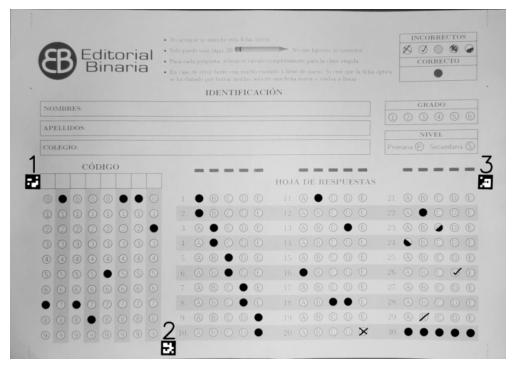

In [6]:
# Detectar aruco
marcadores_aruco = detect_aruco_marker(dilated_image, "DICT_5X5_1000")
print("Marcadores detectados: ", marcadores_aruco)

### **4.1. Separación de Partes de Interes**

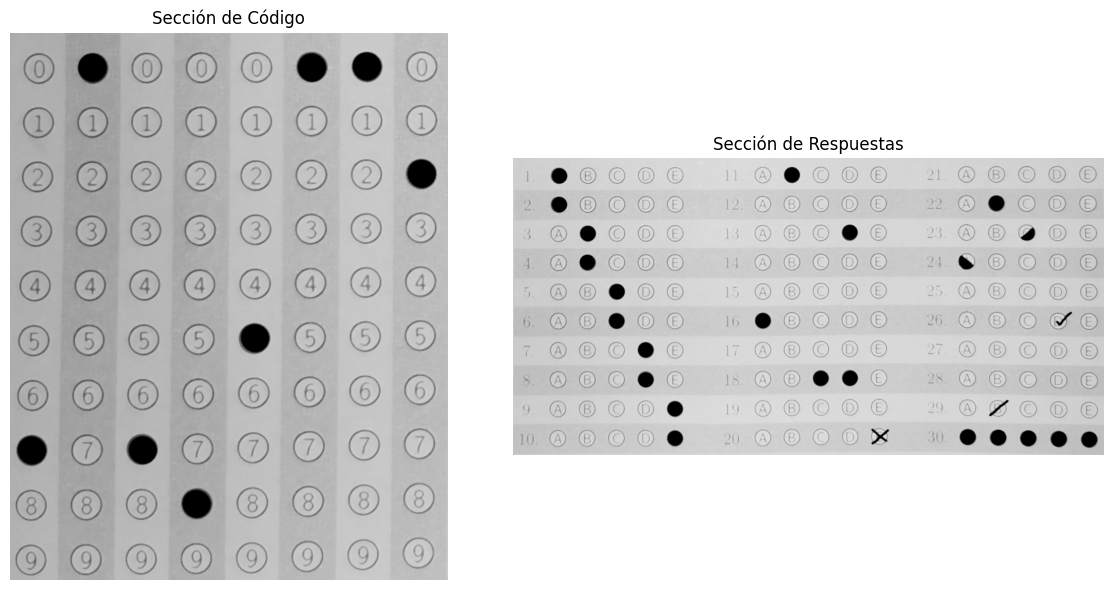

In [6]:
# Separación de la parte del código del estudiante
seccion_codigo = crop_image(dilated_image, marcadores_aruco[1]['bottomRight'], marcadores_aruco[2]['topLeft'])
seccion_respuestas = crop_image(dilated_image, marcadores_aruco[2]['topRight'], marcadores_aruco[3]['bottomLeft'])

# Mostrar Secciones
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(imutils.resize(cv2.cvtColor(seccion_codigo, cv2.COLOR_BGR2RGB), width=800))
ax1.axis("off")
ax1.set_title("Sección de Código")

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(imutils.resize(cv2.cvtColor(seccion_respuestas, cv2.COLOR_BGR2RGB), width=1000))
ax2.axis("off")
ax2.set_title("Sección de Respuestas")

plt.tight_layout()
plt.show()


## **5. Umbralización de las Secciones**

#### **5.1. Umbralización de Sección de Código**

(-0.5, 799.5, 999.5, -0.5)

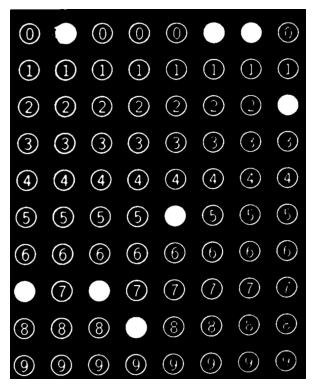

In [7]:
codigo_umbralizado = cv2.threshold(seccion_codigo, 148, 255, cv2.THRESH_BINARY_INV)[1]
plt.imshow(imutils.resize(cv2.cvtColor(codigo_umbralizado, cv2.COLOR_BGR2RGB), width=800))
plt.axis("off")

kernel_size = 1
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
codigo_umbralizado = cv2.morphologyEx(codigo_umbralizado, cv2.MORPH_CLOSE, kernel)


plt.imshow(imutils.resize(cv2.cvtColor(codigo_umbralizado, cv2.COLOR_BGR2RGB), width=800))
plt.axis("off")

#### **5.2. Umbralización de Sección de Respuestas**

(-0.5, 799.5, 401.5, -0.5)

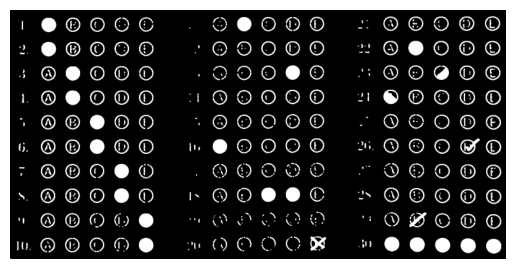

In [8]:
respuestas_umbralizado = cv2.threshold(seccion_respuestas, 150, 255, cv2.THRESH_BINARY_INV)[1]
plt.imshow(imutils.resize(cv2.cvtColor(respuestas_umbralizado, cv2.COLOR_BGR2RGB), width=800))
plt.axis("off")

kernel_size = 4
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
respuestas_umbralizado = cv2.morphologyEx(respuestas_umbralizado, cv2.MORPH_DILATE, kernel)


plt.imshow(imutils.resize(cv2.cvtColor(respuestas_umbralizado, cv2.COLOR_BGR2RGB), width=800))
plt.axis("off")

## **6. Reconocimiento y Agrupamiento de las Burbujas**

### **6.1. Reconocimiento y Agrupamiento en Sección Codigo**

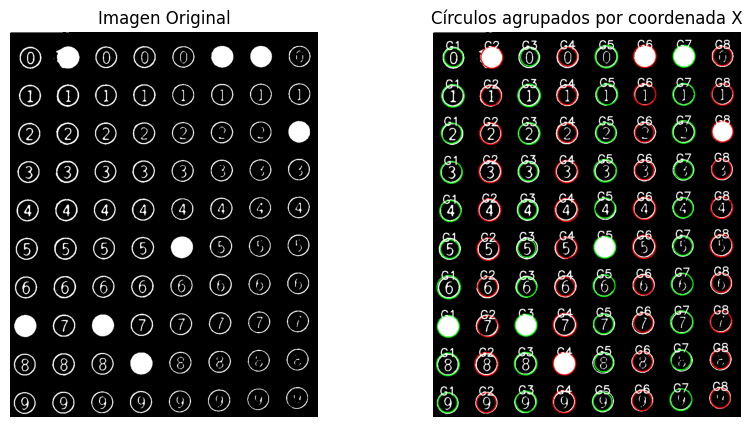

In [9]:
# Cargar la imagen
image = codigo_umbralizado

# Aplicar un desenfoque gaussiano para reducir el ruido
blurred = cv2.GaussianBlur(image, (9, 9), 2)

# Detectar círculos utilizando la Transformada de Hough
circles = cv2.HoughCircles(blurred, 
                           cv2.HOUGH_GRADIENT, dp=1.2, minDist=30, 
                           param1=100, param2=30, 
                           minRadius=10, maxRadius=50)

# Si se detectaron círculos, proceder
if circles is not None:
    # Convertir las coordenadas (x, y) y los radios en enteros
    circles = np.round(circles[0, :]).astype("int")
    
    # Ordenar los círculos por la coordenada X (valor de la primera componente de la tupla)
    sorted_circles = sorted(circles, key=lambda x: x[0])

    # Agrupar los círculos en grupos según sus coordenadas X (columnas)
    groups = []
    current_group = []
    current_x = sorted_circles[0][0]
    for circle in sorted_circles:
        x, y, r = circle
        if abs(x - current_x) > 50:  # Aumentar el umbral para definir un nuevo grupo
            groups.append(current_group)
            current_group = []
            current_x = x
        current_group.append(circle)
    if current_group:
        groups.append(current_group)
    
    # Convertir la imagen original a color para dibujar los círculos
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Dibujar los círculos ordenados y agrupados
    for group_idx, group in enumerate(groups):
        color = (0, 255, 0) if group_idx % 2 == 0 else (255, 0, 0)  # Alternar colores entre grupos
        for (x, y, r) in group:
            cv2.circle(output, (x, y), r, color, 2)
            cv2.putText(output, f"G{group_idx+1}", (x - 20, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Mostrar la imagen original y la imagen con los círculos detectados y agrupados
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Imagen Original')
    plt.axis("off")
    plt.imshow(image, cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title('Círculos agrupados por coordenada X')
    plt.imshow(output)
    plt.axis("off")
    plt.show()
else:
    print("No se detectaron círculos.")


### **6.2. Reconocimiento y Agrupamiento en Sección Respuestas**

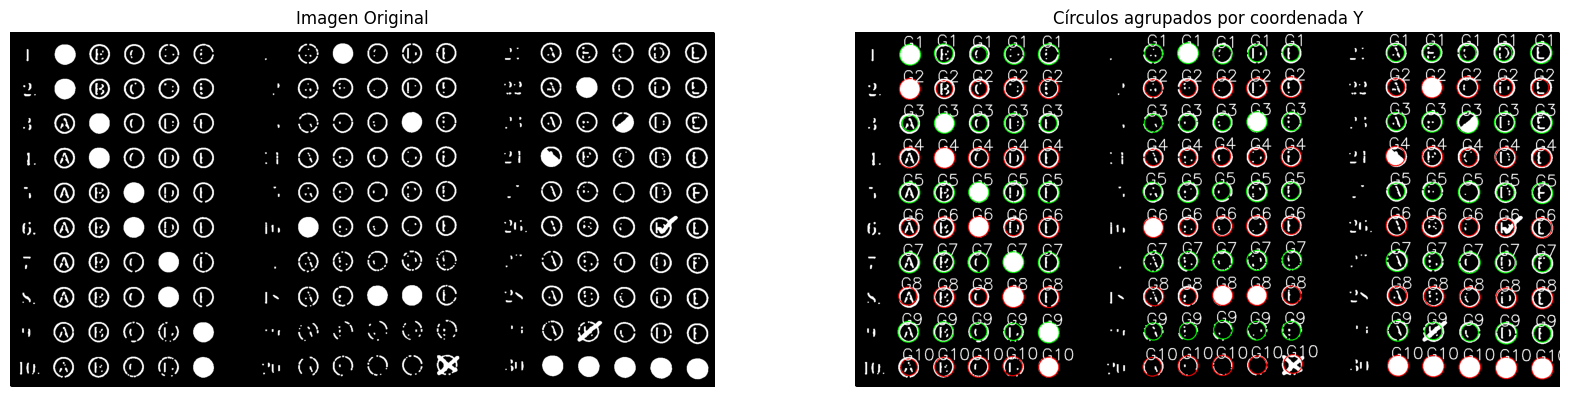

In [10]:
# Cargar la imagen
image = respuestas_umbralizado

# Aplicar un desenfoque gaussiano para reducir el ruido
blurred = cv2.GaussianBlur(image, (9, 9), 2)

# Detectar círculos utilizando la Transformada de Hough
circles = cv2.HoughCircles(blurred, 
                           cv2.HOUGH_GRADIENT, dp=1.2, minDist=30, 
                           param1=100, param2=30, 
                           minRadius=10, maxRadius=50)

# Si se detectaron círculos, proceder
if circles is not None:
    # Convertir las coordenadas (x, y) y los radios en enteros
    circles = np.round(circles[0, :]).astype("int")
    
    # Ordenar los círculos por la coordenada Y (valor de la segunda componente de la tupla)
    sorted_circles = sorted(circles, key=lambda x: x[1])

    # Agrupar los círculos en grupos según sus coordenadas Y (filas)
    groups = []
    current_group = []
    current_y = sorted_circles[0][1]
    for circle in sorted_circles:
        x, y, r = circle
        if abs(y - current_y) > 50:  # Definir un nuevo grupo si la diferencia en Y es significativa
            groups.append(current_group)
            current_group = []
            current_y = y
        current_group.append(circle)
    if current_group:
        groups.append(current_group)
    
    # Convertir la imagen original a color para dibujar los círculos
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Dibujar los círculos ordenados y agrupados
    for group_idx, group in enumerate(groups):
        color = (0, 255, 0) if group_idx % 2 == 0 else (255, 0, 0)  # Alternar colores entre grupos
        for (x, y, r) in group:
            cv2.circle(output, (x, y), r, color, 2)
            cv2.putText(output, f"G{group_idx+1}", (x - 20, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)

    # Mostrar la imagen original y la imagen con los círculos detectados y agrupados
    plt.figure(figsize=(20, 15))
    plt.subplot(1, 2, 1)
    plt.title('Imagen Original')
    plt.axis("off")
    plt.imshow(image, cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title('Círculos agrupados por coordenada Y')
    plt.imshow(output)
    plt.axis("off")
    plt.show()
else:
    print("No se detectaron círculos.")


## **7. Reconocimiento y Creacion de la Matriz para Burbujas Pintadas**

### **7.1. Reconocimiento y Creacion de Matriz en Sección Codigo**

Group 1: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
Group 2: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group 3: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
Group 4: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Group 5: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Group 6: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group 7: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group 8: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


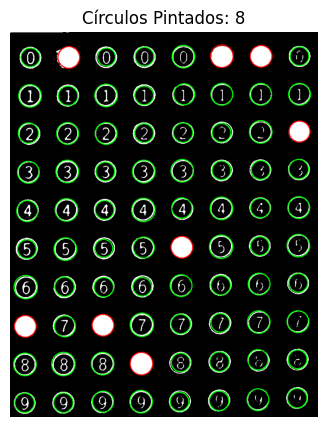

In [16]:
# Cargar la imagen
image = codigo_umbralizado

# Aplicar un desenfoque gaussiano para reducir el ruido
blurred = cv2.GaussianBlur(image, (9, 9), 2)

# Detectar círculos utilizando la Transformada de Hough
circles = cv2.HoughCircles(blurred, 
                           cv2.HOUGH_GRADIENT, dp=1.2, minDist=30, 
                           param1=100, param2=30, 
                           minRadius=10, maxRadius=50)

# Si se detectaron círculos, proceder
if circles is not None:
    # Convertir las coordenadas (x, y) y los radios en enteros
    circles = np.round(circles[0, :]).astype("int")
    
    # Ordenar los círculos por la coordenada X (valor de la primera componente de la tupla)
    sorted_circles = sorted(circles, key=lambda x: x[0])

    # Agrupar los círculos en grupos según sus coordenadas X (columnas)
    groups = []
    current_group = []
    current_x = sorted_circles[0][0]
    for circle in sorted_circles:
        x, y, r = circle
        if abs(x - current_x) > 50:  # Aumentar el umbral para definir un nuevo grupo
            # Ordenar los círculos dentro del grupo por Y antes de añadir el grupo
            current_group = sorted(current_group, key=lambda c: c[1])
            groups.append(current_group)
            current_group = []
            current_x = x
        current_group.append(circle)
    if current_group:
        current_group = sorted(current_group, key=lambda c: c[1])
        groups.append(current_group)
        
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for group in groups:
        for (x, y, r) in group:
            cv2.circle(output, (x, y), r, (0, 255, 0), 2)
    # Crear un array de arrays donde cada grupo tiene 0 o 1 dependiendo del porcentaje de píxeles pintados
    results_codigo = []
    cont = 0
    for group in groups:
        group_result = []
        for (x, y, r) in group:
            if filled_percentage(image, x, y, r) >= 90:  # Reducir el umbral al 95%
                group_result.append(1)
                cont += 1
                cv2.circle(output, (x, y), r, (255, 0, 0), 2)
            else:
                group_result.append(0)
        results_codigo.append(group_result)
    
    # Mostrar el resultado en consola
    for idx, group in enumerate(results_codigo):
        print(f"Group {idx+1}: {group}")


    # Mostrar la imagen original y la imagen con los círculos detectados
    plt.figure(figsize=(10, 5))
    plt.title('Círculos Pintados: '+str(cont))
    plt.axis("off")
    plt.imshow(output)
    plt.show()
else:
    print("No se detectaron círculos.")


### **7.2. Reconocimiento y Creacion de Matriz en Sección Respuestas**

Group 1: [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Group 2: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Group 3: [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Group 4: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group 5: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group 6: [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group 7: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group 8: [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Group 9: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group 10: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


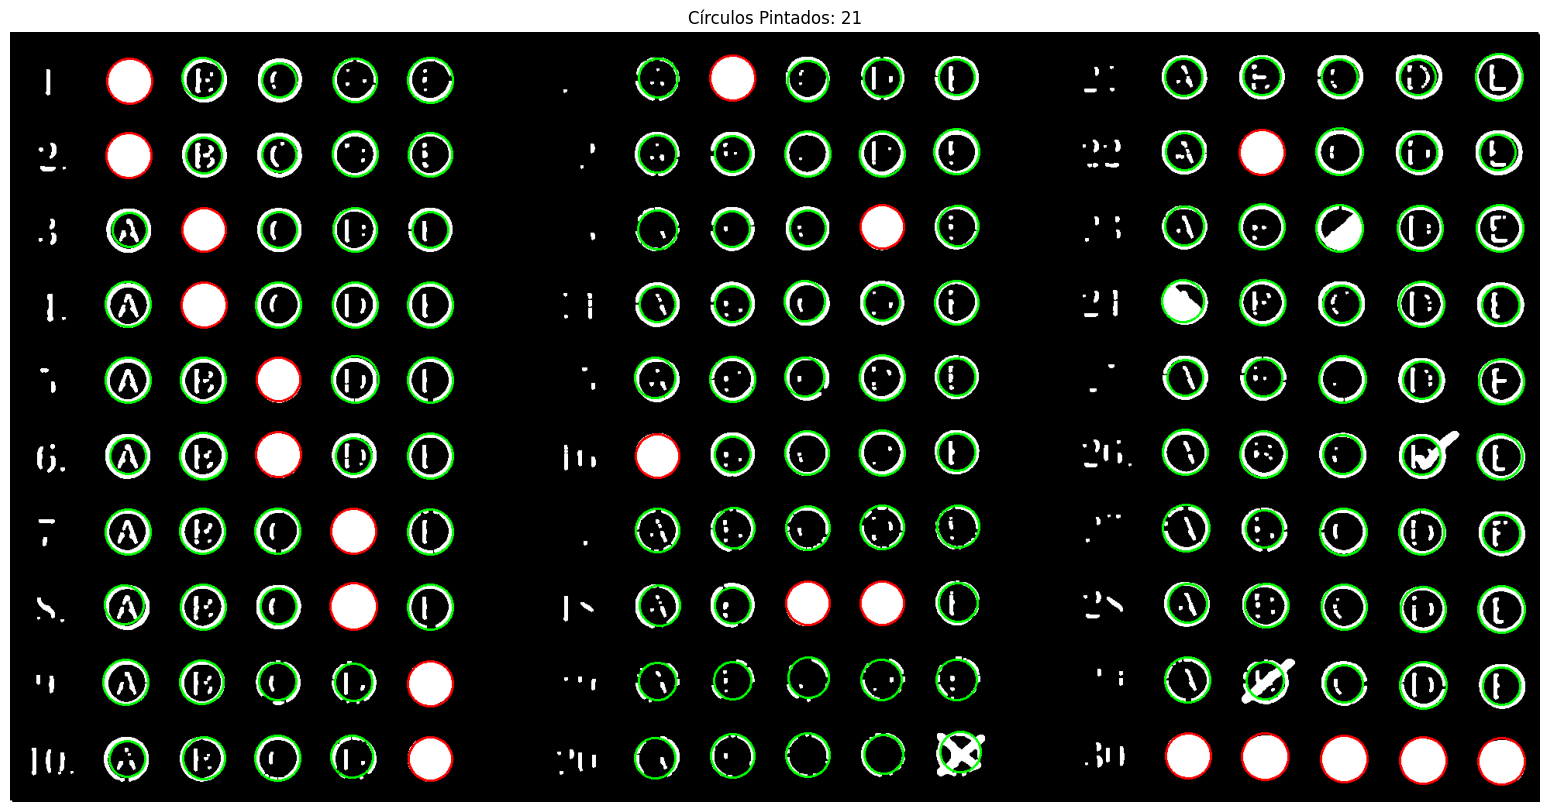

In [17]:
# Cargar la imagen desde la nueva ruta
image = respuestas_umbralizado

# Aplicar un desenfoque gaussiano para reducir el ruido
blurred = cv2.GaussianBlur(image, (9, 9), 2)

# Detectar círculos utilizando la Transformada de Hough
circles = cv2.HoughCircles(blurred, 
                           cv2.HOUGH_GRADIENT, dp=1.2, minDist=30, 
                           param1=100, param2=30, 
                           minRadius=10, maxRadius=50)

# Función para calcular el porcentaje de píxeles pintados dentro de un círculo
def filled_percentage(image, x, y, r):
    mask = np.zeros_like(image)
    cv2.circle(mask, (x, y), r, 255, -1)
    circle_pixels = np.sum(mask == 255)
    filled_pixels = np.sum(cv2.bitwise_and(image, mask) == 255)
    return (filled_pixels / circle_pixels) * 100

# Si se detectaron círculos, proceder
if circles is not None:
    # Convertir las coordenadas (x, y) y los radios en enteros
    circles = np.round(circles[0, :]).astype("int")
    
    # Ordenar los círculos por la coordenada Y (valor de la segunda componente de la tupla)
    sorted_circles = sorted(circles, key=lambda x: x[1])

    # Agrupar los círculos en grupos según sus coordenadas Y (filas)
    groups = []
    current_group = []
    current_y = sorted_circles[0][1]
    for circle in sorted_circles:
        x, y, r = circle
        if abs(y - current_y) > 50:  # Definir un nuevo grupo si la diferencia en Y es significativa
            # Ordenar los círculos dentro del grupo por X antes de añadir el grupo
            current_group = sorted(current_group, key=lambda c: c[0])
            groups.append(current_group)
            current_group = []
            current_y = y
        current_group.append(circle)
    if current_group:
        current_group = sorted(current_group, key=lambda c: c[0])
        groups.append(current_group)

    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for group in groups:
        for (x, y, r) in group:
            cv2.circle(output, (x, y), r, (0, 255, 0), 2)
    
    # Crear un array de arrays donde cada grupo tiene 0 o 1 dependiendo del porcentaje de píxeles pintados
    cont = 0
    results_respuestas = []
    for group in groups:
        group_result = []
        for (x, y, r) in group:
            if filled_percentage(image, x, y, r) >= 91:  # Umbral al 95%
                group_result.append(1)
                cv2.circle(output, (x, y), r, (255, 0, 0), 2)
                cont += 1
            else:
                group_result.append(0)
        results_respuestas.append(group_result)
    
    # Mostrar el resultado en consola
    for idx, group in enumerate(results_respuestas):
        print(f"Group {idx+1}: {group}")

    # Mostrar la imagen original y la imagen con los círculos detectados
    plt.figure(figsize=(20, 10))
    plt.title('Círculos Pintados: '+str(cont))
    plt.axis("off")
    plt.imshow(output)
    plt.show()
else:
    print("No se detectaron círculos.")


## **8. Obtención de Resultados**

In [18]:
# Sección Código
codigo_estudiante = ""
for group in results_codigo:
    num = 0
    for buble in group:
        if buble == 1:
            codigo_estudiante += str(num)
        num += 1
        

# Sección Resultados
ASWERS = np.array([[1, 0, 0, 0, 0,   0, 1, 0, 0, 0,   0, 0, 0, 1, 0],  #1
                   [1, 0, 0, 0, 0,   0, 0, 1, 0, 0,   0, 1, 0, 0, 0],  #2
                   [0, 1, 0, 0, 0,   0, 0, 0, 1, 0,   0, 0, 1, 0, 0],  #3
                   [0, 1, 0, 0, 0,   0, 0, 1, 0, 0,   0, 0, 0, 0, 1],  #4
                   [0, 0, 1, 0, 0,   0, 1, 0, 0, 0,   0, 1, 0, 0, 0],  #5
                   [0, 0, 1, 0, 0,   1, 0, 0, 0, 0,   1, 0, 0, 0, 0],  #6
                   [0, 0, 0, 1, 0,   1, 0, 0, 0, 0,   1, 0, 0, 0, 0],  #7
                   [0, 0, 0, 1, 0,   0, 0, 1, 0, 0,   0, 0, 1, 0, 0],  #8
                   [0, 0, 0, 0, 1,   0, 0, 0, 0, 1,   0, 1, 0, 0, 0],  #9
                   [0, 0, 0, 0, 1,   0, 0, 0, 0, 1,   0, 0, 0, 0, 1]]) #10

results_respuestas = np.array(results_respuestas)
puntaje = 0
for group in range(len(results_respuestas)):
    for buble in range(0, 15, 5):  # Recorre los subgrupos de 5 en 5
        subgrupo = ASWERS[group, buble:buble+5]
        subgrupo_respuestas = results_respuestas[group, buble:buble+5]
        
        # Contar cuántos "1" hay en cada subgrupo
        if np.sum(subgrupo == 1) <= 1 and np.sum(subgrupo_respuestas == 1) <= 1:
            puntaje += np.sum((subgrupo == subgrupo_respuestas) & (subgrupo == 1))
            
print(f'El código del Estudiante es: {codigo_estudiante}')
print(f"Y su puntaje es {puntaje / 30 * 100:.2f}%")

El código del Estudiante es: 70785002
Y su puntaje es 46.67%
